**Choosing Countries** <br>
A total of 25 countires have been choosen. 


*   The first 10 countries are those with high new cases and the include Mexico, Brazil, Ukraine, India, USA, Panama, Hungary, Pakistan, Israel, Bulgaria. (Source : https://www.worldometers.info/coronavirus , retrieved on : April 24, 2020, information last updated on: retrieved on : April 24, 2020).

*  Next 10 countries are those with lowest new cases and they include Spain, Italy, France, Germany, UK, Turkey, Iran, Russia, Belgium, Canada.  (Source : https://www.worldometers.info/coronavirus , retrieved on : April 24, 2020, information last updated on retrieved on : April 24, 2020). 

*  Last 5 countries are those with GDP closer to Pakistan's. Including closest 5 countries which are Bangladesh, India, Nigeria, Vietnam, Egypt. (Source : http://statisticstimes.com/economy/projected-world-gdp-ranking.php , retrieved on : April 24, 2020, information last on 20 Feb 2020).
 



In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import seaborn as sns


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Database working and connection

In [3]:
pip install mysql-connector-python

     |████████████████████████████████| 14.8MB 1.4MB/s 


In [5]:
import mysql.connector
from mysql.connector import Error

In [6]:
def connect_to_db():
  import mysql.connector
  from mysql.connector import Error
  try:
    connection = mysql.connector.connect(host='coviddatabase.cjf2ya4zgyiu.ap-south-1.rds.amazonaws.com',
                                          database='mml_DB',
                                          user='admin',
                                          password='TMg(XY8yRtB1*FcV')
    
  except:
    print("Connection Error")
  return connection

connection = connect_to_db()

def send_data_to_country_table(covid_data, con):
  country_table = covid_data[["location", "continent", "population_density", "median_age", "aged_65_older", "gdp_per_capita", "extreme_poverty", "cvd_death_rate", "diabetes_prevalence", "female_smokers", "male_smokers", "handwashing_facilities", "hospital_beds_per_thousand"]]
  country_table = country_table.drop_duplicates()
  
  country_table = country_table.fillna(-1) #filling na with -1
  cursor = con.cursor()
  tuples = [tuple(row) for index,row in country_table.iterrows()] #chaning to tuples
  mySql_insert_query = "INSERT IGNORE INTO country (location, continent, population_density, median_age, aged_65_older, gdp_per_capita, extreme_poverty, cvd_death_rate, diabetes_prevalence, female_smokers, male_smokers, handwashing_facilities, hospital_beds_per_thousand) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)"
  cursor.executemany(mySql_insert_query, tuples)
  con.commit()

def send_data_to_cases_table(covid_data, con):
  cases_table = covid_data[["date", "location", "new_cases", "stringency_index"]]
  cases_table = cases_table.fillna(-1)

  cursor = con.cursor()
  sql_select_Query = "select MAX(date) from Cases"

  dates = pd.read_sql(sql_select_Query, con = con, parse_dates = ['MAX(date)'])
  last_date = pd.to_datetime(dates["MAX(date)"].values[0]) #last date we updated the data

  cases_table = covid_data[covid_data["date"] > last_date] #only adding new data

  tuples = [tuple(row) for index,row in cases_table.iterrows()]
  mySql_insert_query = "INSERT IGNORE INTO Cases (date, location, new_cases, stringency_index) VALUES (%s, %s, %s, %s)"
  cursor.executemany(mySql_insert_query, tuples)
  con.commit()

In [7]:
def update_data_in_db():
  """
  Call this function to scrap data from website and insert into DB
  """
  covid_data = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv',parse_dates=['date'])
  connection = connect_to_db()
  send_data_to_country_table(covid_data, connection)
  send_data_to_cases_table(covid_data, connection)
  connection.close()

In [10]:
def read_data_from_db_to_df():
  """
  Reads data from DB and returns a dataframe
  """
  connection = connect_to_db()
  cursor = connection.cursor()
  sql_select_Query = "select * from country"
  country_table = pd.read_sql(sql_select_Query, con = connection) #whole country table as df
  sql_select_Query = "select * from Cases"
  cases_table = pd.read_sql(sql_select_Query, con = connection) #whole cases table as df
  joined = pd.merge(cases_table, country_table, on='location', how='left') #joining both
  joined = joined.replace(to_replace = -1, value = np.nan)
  connection.close()
  return joined
  

covid_data = read_data_from_db_to_df()

##Loading Data

In [ ]:
covid_data = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv',parse_dates=['date'])

In [ ]:
## This was only run once on 15 June 2020 to get the countries with most covid cases. The countries' data was then
## used for a analysis.

# a = covid_data.copy()
# a = a.sort_values(by='total_cases',ascending=False)
# top_location = a.location.unique().tolist()
# top_location[:40]

In [ ]:
countries_diff_format = ['United States', 'Brazil', 'Russia', 'India', 'United Kingdom', 'Peru', 'Spain', 'Italy', 'Chile', 'Iran', 'Germany', 'Turkey', 'Pakistan', 'Mexico', 'France', 'Saudi Arabia', 'Bangladesh', 'Canada', 'South Africa', 'Qatar', 'China', 'Colombia', 'Belgium', 'Belarus', 'Sweden', 'Egypt', 'Ecuador', 'Netherlands', 'Indonesia', 'United Arab Emirates', 'Singapore', 'Argentina', 'Kuwait', 'Portugal', 'Ukraine', 'Poland', 'Switzerland', 'Philippines', 'Iraq', 'Oman']

#Sorting data by dates (Times series)
covid_data = covid_data.sort_values(by='date',ascending=True)

In [11]:
covid_data.dtypes

date                          datetime64[ns]
location                              object
new_cases                              int64
stringency_index                     float64
continent                             object
population_density                   float64
median_age                           float64
aged_65_older                        float64
gdp_per_capita                       float64
extreme_poverty                      float64
cvd_death_rate                       float64
diabetes_prevalence                  float64
female_smokers                       float64
male_smokers                         float64
handwashing_facilities               float64
hospital_beds_per_thousand           float64
dtype: object

### Pearson’s Correlation Coefficient Matrix
According to Halkjaer and Winther, the correlations in the input data severely slow down learning therefore, we used Pearson Correlation Coefficient Matrix to determine the correlation between the input data and new_cases. All the variables having a Pearson Correlation, P, greater than |P| > 0.1 are dropped.


In [16]:
data[data.columns[:]].corr()['new_cases'][:]

new_cases                     1.000000
stringency_index              0.108147
population_density           -0.018144
median_age                    0.018765
aged_65_older                 0.014319
gdp_per_capita                0.009599
extreme_poverty              -0.029273
cvd_death_rate               -0.029963
diabetes_prevalence           0.018983
female_smokers               -0.007828
male_smokers                 -0.006197
handwashing_facilities        0.022309
hospital_beds_per_thousand   -0.014647
Name: new_cases, dtype: float64

<Figure size 432x288 with 0 Axes>

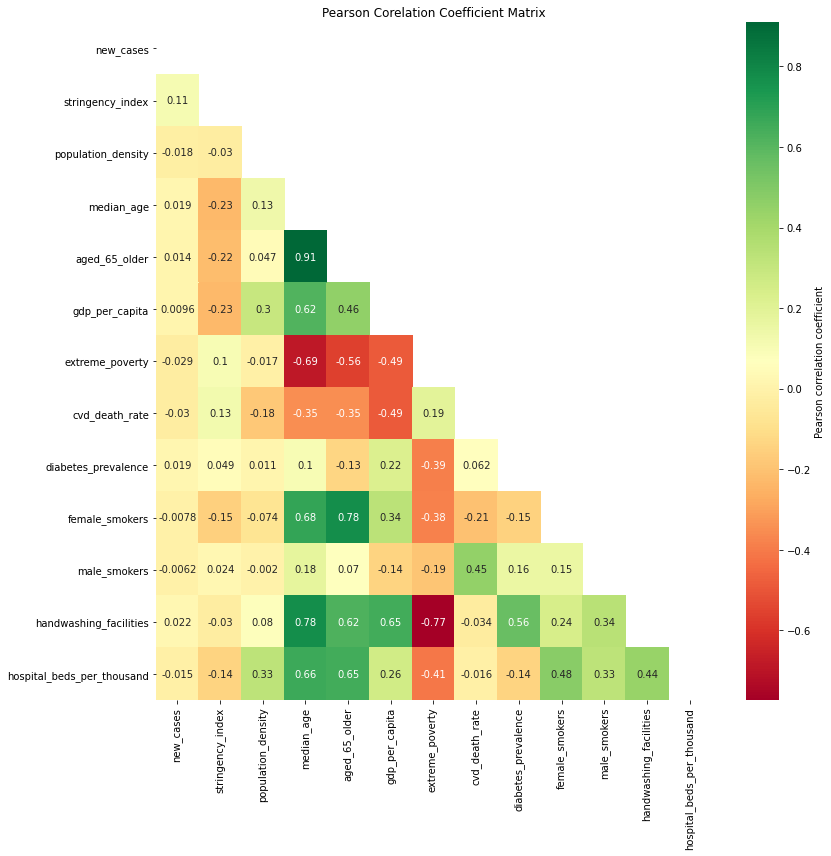

In [17]:
plt.clf()

corr = data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(12,12))

fig = sns.heatmap(corr, mask=mask, square=False, cmap='RdYlGn', annot=True, ax=ax, 
            cbar_kws={'label':'Pearson correlation coefficient'})

fig.set_title('Pearson Corelation Coefficient Matrix')
fig.tick_params(axis='x', rotation=90)
fig.tick_params(axis='y', rotation=0)

fig = fig.get_figure()
fig.tight_layout()
fig.show()

Dropping columns with |P| > 0.1

In [ ]:
# not removing total_Cases now because they will be used to make data categorical
data = data.drop(['population','new_tests','total_deaths'],1)

In [ ]:
data.columns

Index(['location', 'date', 'total_cases', 'new_cases', 'stringency_index',
       'population_density', 'median_age', 'aged_65_older', 'aged_70_older',
       'gdp_per_capita', 'extreme_poverty', 'cvd_death_rate',
       'diabetes_prevalence', 'female_smokers', 'male_smokers',
       'handwashing_facilities', 'hospital_beds_per_thousand',
       'life_expectancy'],
      dtype='object')

## Making data categorcial for location and data
All countries are one-hot encoded, i.e., for each country a seperate column is assigned. 


In [ ]:
data['number_of_days'] = -1

In [ ]:
#adding location again
data['location'] = covid_data['location']

#changing location to categorical by having a column for every country

for i in countries_diff_format:
  data[i] = 0

for i in countries_diff_format:
  data.loc[data['location'] == i, i] = 1
data = data.drop(data.loc[np.isin(data["location"], countries_diff_format, invert = True)].index)


# Dealing with number of days
Number of days is the number of days from the date first case was reported in a country.

In [ ]:
df = data.copy(deep=True)

for i in countries_diff_format:

   # the date where first case was reported in a country
  start_date = min(df[(df[i] == 1) & (df.total_cases > 0)]["date"])
  
  #Count of day from the day when first case was reported
  df.loc[(df[i] == 1),'number_of_days'] = (df.loc[(df[i] == 1),'date'] - start_date).dt.days


df = df.drop(df.loc[(df["number_of_days"] < 0)].index)
for i in countries_diff_format:
    print(df[(df[i]==1) & (df["number_of_days"]==0)][["date"]].tail(1), i)


            date
23744 2020-01-21 United States
           date
3316 2020-02-26 Brazil
            date
18977 2020-02-01 Russia
            date
10546 2020-01-30 India
            date
23580 2020-01-31 United Kingdom
            date
18018 2020-03-07 Peru
            date
21164 2020-02-01 Spain
            date
11673 2020-01-31 Italy
           date
4729 2020-03-04 Chile
            date
10907 2020-02-20 Iran
           date
8745 2020-01-28 Germany
            date
23089 2020-03-12 Turkey
            date
17494 2020-02-27 Pakistan
            date
14964 2020-02-29 Mexico
           date
8106 2020-01-25 France
            date
19742 2020-03-03 Saudi Arabia
           date
1963 2020-03-09 Bangladesh
           date
4202 2020-01-26 Canada
            date
20773 2020-03-06 South Africa
            date
18664 2020-03-01 Qatar
           date
4838 2019-12-31 China
           date
5014 2020-03-07 Colombia
           date
2373 2020-02-04 Belgium
           date
2223 2020-02-28 Belarus
        

# Dealing with NaN values

In [ ]:
# a = data.copy(deep =True)
# p = a[a.Pakistan ==1]
# s_d = p.loc[(p.total_cases > 0)].date.iloc[0]
# p.number_of_days = p.date - s_d
# #print(p.number_of_days)
# p.drop(p[p.date < s_d].index,inplace = True)
# print(p.number_of_days)

#print(df[df["number_of_days"] == 0].to_csv("testing.csv"))
df["number_of_days"].value_counts()

101.0    40
68.0     40
59.0     40
66.0     40
78.0     40
         ..
168.0     1
160.0     1
155.0     1
153.0     1
157.0     1
Name: number_of_days, Length: 174, dtype: int64

In [ ]:
print(df[df["number_of_days"] == 0][["date"]])

            date
4838  2019-12-31
23744 2020-01-21
20284 2020-01-24
8106  2020-01-25
4202  2020-01-26
23408 2020-01-27
8745  2020-01-28
10546 2020-01-30
18155 2020-01-30
23580 2020-01-31
11673 2020-01-31
18977 2020-02-01
21164 2020-02-01
21795 2020-02-01
2373  2020-02-04
6956  2020-02-15
10907 2020-02-20
12648 2020-02-24
11086 2020-02-25
17324 2020-02-25
3316  2020-02-26
21994 2020-02-26
17494 2020-02-27
16280 2020-02-28
2223  2020-02-28
14964 2020-02-29
18664 2020-03-01
6802  2020-03-01
10751 2020-03-02
18406 2020-03-03
19742 2020-03-03
811   2020-03-04
4729  2020-03-04
23281 2020-03-04
18295 2020-03-04
20773 2020-03-06
18018 2020-03-07
5014  2020-03-07
1963  2020-03-09
23089 2020-03-12


In [ ]:
#df = data.copy()
#df = df.drop('date',axis = 1)

#df.set_index(['row_number'])
#df = df.fillna(0)
print(df.isnull().sum())
print(df[np.isnan(df["hospital_beds_per_thousand"])]["location"].value_counts())

location                         0
date                             0
total_cases                     30
new_cases                       30
stringency_index               287
population_density               0
median_age                       0
aged_65_older                    0
aged_70_older                    0
gdp_per_capita                   0
extreme_poverty               1627
cvd_death_rate                   0
diabetes_prevalence              0
female_smokers                 116
male_smokers                   223
handwashing_facilities        3574
hospital_beds_per_thousand       0
life_expectancy                  0
United States                    0
Brazil                           0
Russia                           0
India                            0
United Kingdom                   0
Peru                             0
Spain                            0
Italy                            0
Chile                            0
Iran                             0
Germany             

In [ ]:
#dealing for missing stringent_index
for i in countries_diff_format:

   # the date where first case was reported in a country
    last_stringent = df[(df[i] == 1 & ~np.isnan(df["stringency_index"]))]["stringency_index"]
    print(i)
    last_stringent = (last_stringent[~np.isnan(last_stringent)].values[-1])
  
  #Count of day from the day when first case was reported
    df.loc[(df[i] == 1 & np.isnan(df["stringency_index"])),'stringency_index'] = last_stringent

United States
Brazil
Russia
India
United Kingdom
Peru
Spain
Italy
Chile
Iran
Germany
Turkey
Pakistan
Mexico
France
Saudi Arabia
Bangladesh
Canada
South Africa
Qatar
China
Colombia
Belgium
Belarus
Sweden
Egypt
Ecuador
Netherlands
Indonesia
United Arab Emirates
Singapore
Argentina
Kuwait
Portugal
Ukraine
Poland
Switzerland
Philippines
Iraq
Oman


In [ ]:
#deleting all rows where number of cases is missing.Doing this cos only 31 rows have missing cases
df = df.drop(df.loc[np.isnan(df["new_cases"])].index)

In [ ]:
# dropping extreme_povery and handwashing_facilities as it have large number of rows with NaN values
df = df.drop( "extreme_poverty",1)
df = df.drop("handwashing_facilities", axis = 1)

# Replacing female_smokers and male_smokers value with countries having missing value with country having similar value

df.loc[(df['Iraq'] == 1), 'female_smokers'] = np.mean(df[df["Iran"] == 1]['female_smokers'])
df.loc[(df['Iraq'] == 1), 'male_smokers'] = np.mean(df[df["Iran"] == 1]['male_smokers'])
df.loc[(df['Peru'] == 1), 'male_smokers'] = np.mean(df[df["Brazil"] == 1]['male_smokers'])

In [ ]:
# now dropping total cases too as corelation was high
df = df.drop('total_cases',1)

In [ ]:
print(df.isnull().sum())

location                      0
date                          0
new_cases                     0
stringency_index              0
population_density            0
median_age                    0
aged_65_older                 0
aged_70_older                 0
gdp_per_capita                0
cvd_death_rate                0
diabetes_prevalence           0
female_smokers                0
male_smokers                  0
hospital_beds_per_thousand    0
life_expectancy               0
United States                 0
Brazil                        0
Russia                        0
India                         0
United Kingdom                0
Peru                          0
Spain                         0
Italy                         0
Chile                         0
Iran                          0
Germany                       0
Turkey                        0
Pakistan                      0
Mexico                        0
France                        0
Saudi Arabia                  0
Banglade

# Visualizing Pak Cases

In [ ]:
pak_cases = df[df['Pakistan'] == 1] 

Pakistan    111
Name: location, dtype: int64


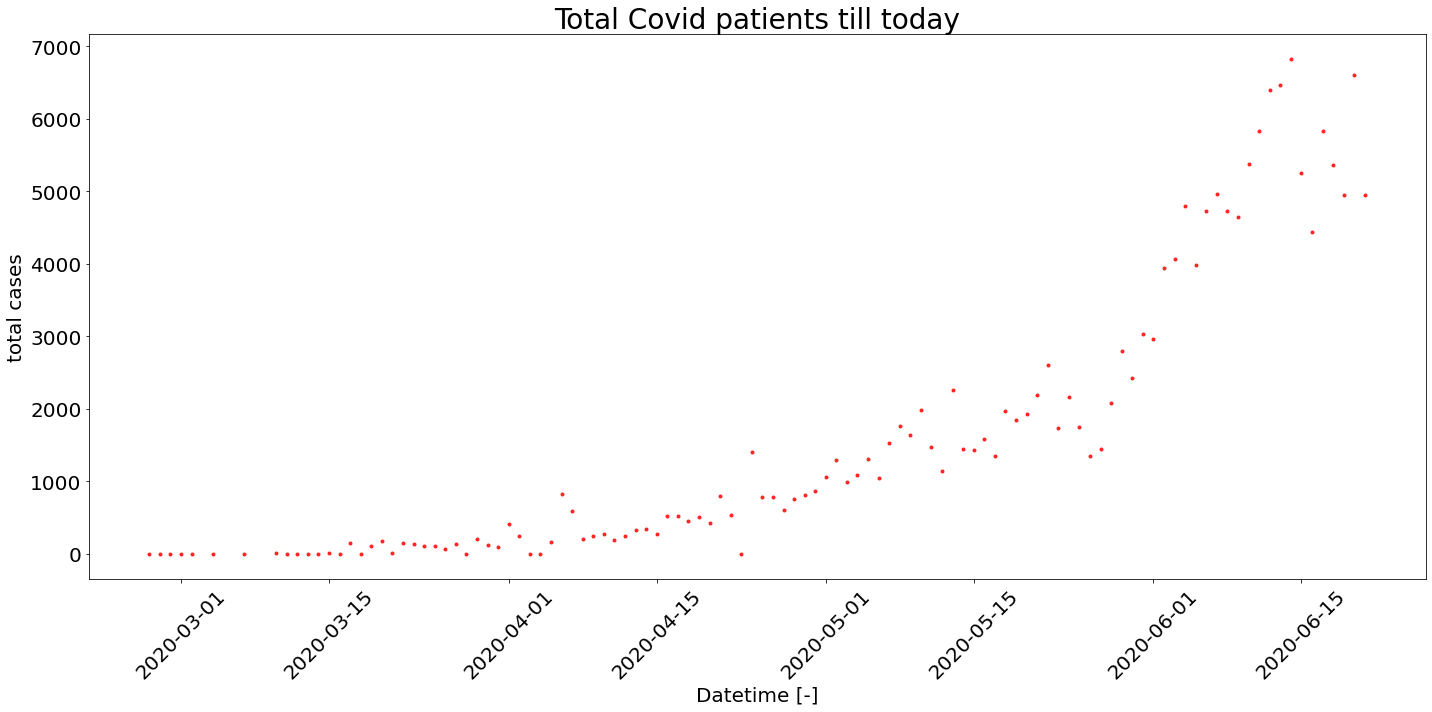

In [ ]:
# Plotting the target: Total cases
print(pak_cases["location"].value_counts())

plt.figure(figsize=(20,10))

plt.plot(pak_cases["date"], pak_cases['new_cases'], '.', color='red', label='Original data', alpha=0.8)
plt.xlabel('Datetime [-]', fontsize=20)
plt.ylabel(r'total cases', fontsize=20)

plt.xticks(fontsize=20, rotation=45)
plt.yticks(fontsize=20)

plt.title('Total Covid patients till today', fontsize=28)

plt.tight_layout()

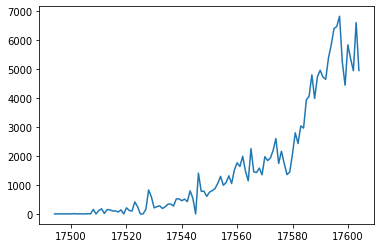

In [ ]:
plt.plot(pak_cases['new_cases'])
plt.show()

In [ ]:
df.dtypes

location                              object
date                          datetime64[ns]
new_cases                            float64
stringency_index                     float64
population_density                   float64
median_age                           float64
aged_65_older                        float64
aged_70_older                        float64
gdp_per_capita                       float64
cvd_death_rate                       float64
diabetes_prevalence                  float64
female_smokers                       float64
male_smokers                         float64
hospital_beds_per_thousand           float64
life_expectancy                      float64
United States                          int64
Brazil                                 int64
Russia                                 int64
India                                  int64
United Kingdom                         int64
Peru                                   int64
Spain                                  int64
Italy     

#Splitting into training and tests data

In [ ]:
# For splitting wrt to a split index

# y = df['new_cases']

# X = df.drop(['new_cases'], axis=1)
# X = X.drop(["location", "date"], axis = 1)
# train_size = 0.7

# split_index = int(df.shape[0]*train_size) #index at which the datafram will be split

# X_train = X[:split_index]
# y_train = y[:split_index]

# X_test = X[split_index:]
# y_test = y[split_index:]

# Choosing Pak last 40 days as test data

# X = df.copy(deep = True)
# X = X.drop(["location", "date"], axis = 1)
# t = df[(df["Pakistan"] == 1)]["number_of_days"]

# train_set = X.drop(X[(X["Pakistan"] == 1) & (X["number_of_days"] >= max(t) -40)].index, axis = 0)
# y = train_set["new_cases"]

# test_set = X[(X["Pakistan"] == 1) & (X["number_of_days"] >= max(t) -40)]
# y_test = test_set["new_cases"]
# X_test = test_set.drop(["new_cases"], axis = 1)

# y_train = train_set["new_cases"]
# X_train = train_set.drop(["new_cases"], axis = 1)


# test_set = X[(X["Pakistan"] == 1) & (X["number_of_days"] >= max(t) -40)]
# y_test = test_set["new_cases"]
# X_test = test_set.drop(["new_cases"], axis = 1)

# print((X_train.shape, y_train.shape))
# print(X_val.shape,y_val.shape)
# print((X_test.shape, y_test.shape))


# Keeping test data to be last 5 days of all countries
# X = df.copy(deep =True)
# X = X.drop('location',1)

# max_date = max(X['date'])
# days_to_get = pd.to_timedelta('15 days 00:00:00')
# old_date = max_date - days_to_get

# test_set = X[(X['date'] > old_date) & (X['date'] <= max_date)]
# train_set = X[(X['date'] <= old_date)]
# test_set.to_csv('checking test.csv')

# train_set = train_set.drop('date',1)
# test_set = test_set.drop('date',1)

# y_train = train_set["new_cases"]
# X_train = train_set.drop(["new_cases"], axis = 1)

# y_test = test_set["new_cases"]
# X_test = test_set.drop(["new_cases"], axis = 1)


# taking pak as test and world as train

X = df.copy(deep = True)
X = X.drop(["location", "date"], axis = 1)
t = df[(df["Pakistan"] == 1)]
test_set = X[(X["Pakistan"] == 1) | (X["India"] == 1)]

train_set = X[(X["Pakistan"] != 1) | (X["India"] != 1)]

y_train = train_set["new_cases"]
X_train = train_set.drop(["new_cases"], axis = 1)

y_test = test_set["new_cases"]
X_test = test_set.drop(["new_cases"], axis = 1)

#world and pak_data sets
X = df.copy(deep =True)
X= X.drop(['location','date'],1)
world_y = X[(X['Pakistan'] != 1)]['new_cases']
world_data = X[X['Pakistan']!=1]
world_data= world_data.drop('new_cases',1)


train_size = 0.75

split_index = int(df.shape[0]*train_size) #index at which the datafram will be split

world_X_train = world_data[:split_index]
world_y_train = world_y[:split_index]

world_X_test = world_data[split_index:]
world_y_test = world_y[split_index:]

pak_cases = X[X['Pakistan']==1]

pak_y = pak_cases['new_cases']
pak_data = pak_cases.drop('new_cases',1)

split_index = int(pak_cases.shape[0]*train_size)

pak_X_train = pak_data[:split_index]
pak_y_train = pak_y[:split_index]

pak_X_test = pak_data[split_index:]
pak_y_test = pak_y[split_index:]

print('world data dimenstions : ',world_X_train.shape,world_y_train.shape,world_X_test.shape,world_y_test.shape)
print('pak data dimenstions : ',pak_X_train.shape,pak_y_train.shape,pak_X_test.shape,pak_y_test.shape)

world data dimenstions :  (3702, 53) (3702,) (1124, 53) (1124,)
pak data dimenstions :  (83, 53) (83,) (28, 53) (28,)


In [ ]:
from sklearn.preprocessing import StandardScaler
scalerX = StandardScaler(with_mean=True, with_std=True).fit(X_train)

# X_train = scalerX.transform(X_train)
# X_test = scalerX.transform(X_test)
# X_val = scalerX.transform(X_val)

# print((X_train.shape, y_train.shape))
# print(X_val.shape,y_val.shape)
# print((X_test.shape, y_test.shape))

world_X_train = scalerX.transform(X_train)
world_X_test = scalerX.transform(X_test)
world_y_test = y_test
world_y_train = y_train

pak_X_train = scalerX.transform(pak_X_train)
pak_X_test = scalerX.transform(pak_X_test)

print('world data dimenstions : ',world_X_train.shape,world_X_test.shape)
print('pak data dimenstions : ',pak_X_train.shape,pak_X_test.shape)

world data dimenstions :  (4937, 53) (254, 53)
pak data dimenstions :  (83, 53) (28, 53)


In [ ]:
from sklearn.metrics import mean_squared_error
df_regression = df['new_cases']

df_regression = df.copy(deep = True)
train_size = 0.8

split_index = int(df.shape[0]*train_size) #index at which the datafram will be split

train = df_regression[:split_index]
train_y = train["new_cases"]


test = df_regression[split_index:]
test_y = test["new_cases"]

import statsmodels.api as sm

model = sm.OLS.from_formula(formula = 'new_cases ~ 1 + number_of_days + I(number_of_days ** 2) + I(number_of_days ** 3)  + C(location)', data = train).fit()
print(model.summary())
pred_train = model.predict(train)
print(np.sqrt(mean_squared_error(pred_train, train_y)))

pred_test = model.predict(test)
print(np.sqrt(mean_squared_error(pred_test, test_y)))

# Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(world_X_train, world_y_train)
model.score(world_X_test, world_y_test)

0.489263966693817

In [ ]:
y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error
#print(mean_squared_error(y_test,y_pred))
#print(y_pred, y_test)
print(np.sqrt(mean_squared_error(world_y_test,y_pred)))

2.7374159875117626e+20


In [ ]:
# DO NOT RUN THIS 
X_test = X[split_index:]
pak_indices_dates = []

pak_indices = list(X_test[X_test['Pakistan']==1].index)

for i in pak_indices:
    pak_indices_dates.append(data.date.loc[[i]].values[0])

X_test_1 = X[split_index:]
X_test_1["test_number"] = np.arange(len(X_test_1))
y_pred_pak_indices = X_test_1[X_test_1['Pakistan']==1]
pak_y_pred= y_pred[y_pred_pak_indices.test_number.tolist()]
print("pak_y_pred shape",pak_y_pred.shape)

pak_y_test= y_test.to_numpy()[y_pred_pak_indices.test_number.tolist()]
print("pak_y_test shape",pak_y_test.shape)

In [ ]:
# Plotting the target: Total cases

plt.figure(figsize=(20,10))

plt.plot(pak_indices_dates, pak_y_pred, '.', color='blue', label='Predicted data', alpha=0.8,markersize =10)
plt.plot(pak_indices_dates, pak_y_test, '.', color='red', label='Actual data', alpha=0.8,markersize =10)
plt.legend()
plt.xlabel('Datetime [-]', fontsize=20)
plt.ylabel(r'new cases', fontsize=20)

plt.xticks(fontsize=20, rotation=45)
plt.yticks(fontsize=20)

plt.title('Actual vs Linear Regression Predicted Cases', fontsize=28)

plt.tight_layout()


In [ ]:
from sklearn import neighbors
model = neighbors.KNeighborsRegressor(3)
model.fit(X_train, y_train)


from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_train)
print("train errors")
print(mean_squared_error(y_train,y_pred))
print(np.sqrt(mean_squared_error(y_train,y_pred)))
print("--")
print("test errors")
y_pred = model.predict(X_test)
print(mean_squared_error(y_test,y_pred))
print(np.sqrt(mean_squared_error(y_test,y_pred)))

train errors
493139.51343290426
702.2389290212443
--
test errors
1186637.3888888883
1089.3288708598925


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


pak_y_pred shape (0,)
pak_y_test shape (0,)


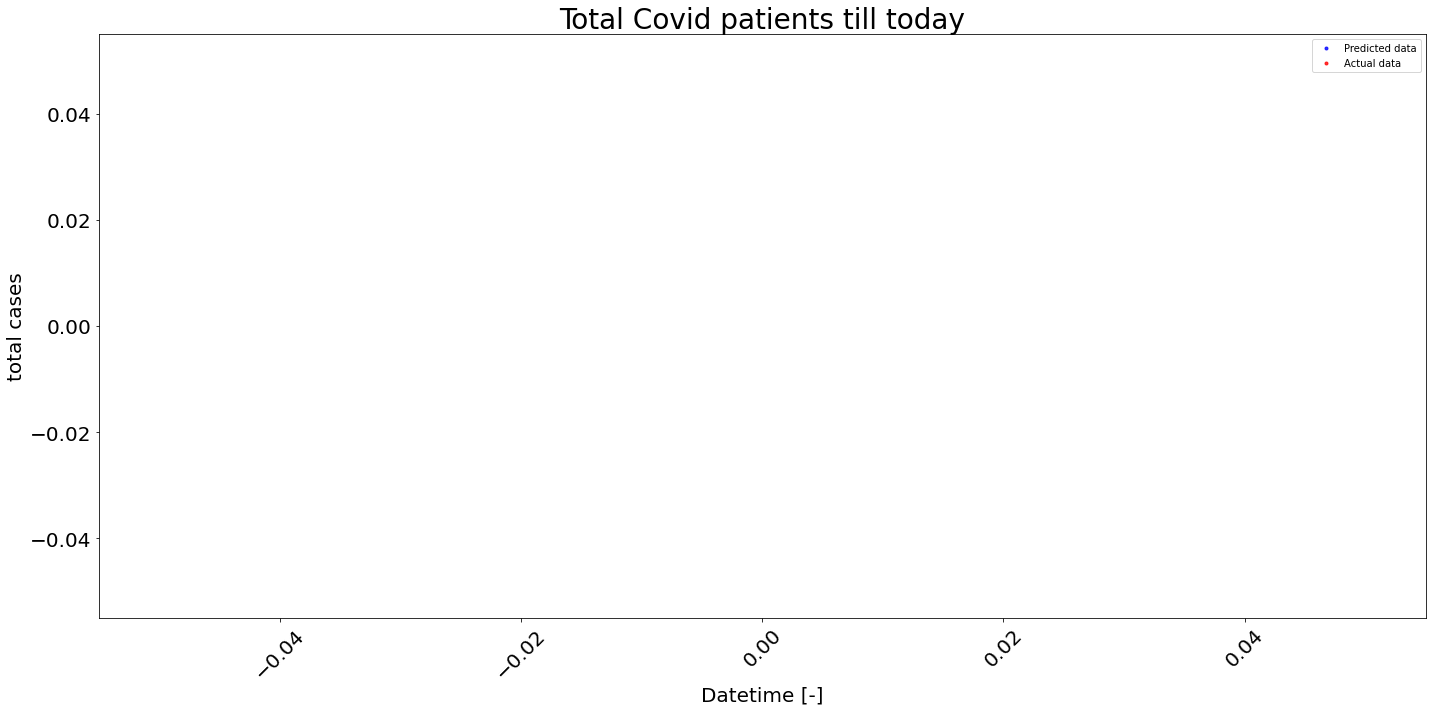

In [ ]:
#DO NOT RUN THIS
X_test = X[split_index:]
pak_indices_dates = []

pak_indices = list(X_test[X_test['Pakistan']==1].index)

for i in pak_indices:
    pak_indices_dates.append(data.date.loc[[i]].values[0])

X_test_1 = X[split_index:]
X_test_1["test_number"] = np.arange(len(X_test_1))
y_pred_pak_indices = X_test_1[X_test_1['Pakistan']==1]
pak_y_pred= y_pred[y_pred_pak_indices.test_number.tolist()]
print("pak_y_pred shape",pak_y_pred.shape)

pak_y_test= y_test.to_numpy()[y_pred_pak_indices.test_number.tolist()]
print("pak_y_test shape",pak_y_test.shape)

plt.figure(figsize=(20,10))

plt.plot(pak_indices_dates, pak_y_pred, '.', color='blue', label='Predicted data', alpha=0.8)
plt.plot(pak_indices_dates, pak_y_test, '.', color='red', label='Actual data', alpha=0.8)
plt.legend()
plt.xlabel('Datetime [-]', fontsize=20)
plt.ylabel(r'total cases', fontsize=20)

plt.xticks(fontsize=20, rotation=45)
plt.yticks(fontsize=20)

plt.title('Total Covid patients till today', fontsize=28)

plt.tight_layout()


In [ ]:
#DO NOT RUN THIS CELL
from sklearn.svm import SVR
from sklearn import neighbors
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import BaggingRegressor


model = BaggingRegressor(max_features = 35)
model.fit(X_train, y_train)


from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_train)
print("train errors")
print(mean_squared_error(y_train,y_pred))
print(np.sqrt(mean_squared_error(y_train,y_pred)))
print("--")
print("test errors")
y_pred = model.predict(X_test)
print(mean_squared_error(y_test,y_pred))
print(np.sqrt(mean_squared_error(y_test,y_pred)))

X_test = X[split_index:]
pak_indices_dates = []

pak_indices = list(X_test[X_test['Pakistan']==1].index)

for i in pak_indices:
    pak_indices_dates.append(data.date.loc[[i]].values[0])

X_test_1 = X[split_index:]
X_test_1["test_number"] = np.arange(len(X_test_1))
y_pred_pak_indices = X_test_1[X_test_1['Pakistan']==1]
pak_y_pred= y_pred[y_pred_pak_indices.test_number.tolist()]
print("pak_y_pred shape",pak_y_pred.shape)

pak_y_test= y_test.to_numpy()[y_pred_pak_indices.test_number.tolist()]
print("pak_y_test shape",pak_y_test.shape)

plt.figure(figsize=(20,10))

plt.plot(pak_indices_dates, pak_y_pred, '.', color='blue', label='Predicted data', alpha=0.8)
plt.plot(pak_indices_dates, pak_y_test, '.', color='red', label='Actual data', alpha=0.8)
plt.legend()
plt.xlabel('Datetime [-]', fontsize=20)
plt.ylabel(r'total cases', fontsize=20)

plt.xticks(fontsize=20, rotation=45)
plt.yticks(fontsize=20)

plt.title('Total Covid patients till today', fontsize=28)

plt.tight_layout()


# Deep Neural Network

In [ ]:
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, SGD, Nadam
from tensorflow.keras import regularizers
from keras.optimizers import Adam

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Conv1D, MaxPool2D, Flatten, Dropout
from keras.optimizers import Adam
from time import time
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

In [ ]:
print((X_train.shape, y_train.shape))
print((X_test.shape, y_test.shape))

((4650, 53), (4650,))
((199, 53), (199,))


In [ ]:
model = Sequential()
model.add(Dense(32, input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l2(0.01), use_bias=False))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.08))

model.add(Dense(512, kernel_regularizer=regularizers.l2(0.01), use_bias=False))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.15))   

model.add(Dense(256, kernel_regularizer=regularizers.l2(0.01), use_bias=False))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.15))   

model.add(Dense(32, kernel_regularizer=regularizers.l2(0.01), use_bias=False))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.15))   

model.add(Dense(1))


In [ ]:
Adam = Adam(lr = 0.0001)
model.compile(optimizer = Adam, loss = 'mse', metrics = ['mse'])
hist = model.fit(X_train, y_train, epochs = 100, batch_size = 32, validation_data = (X_test,y_test))

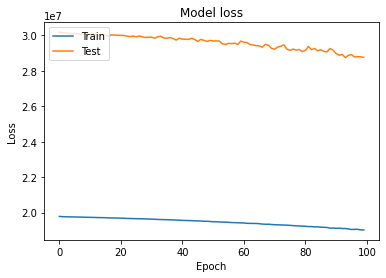

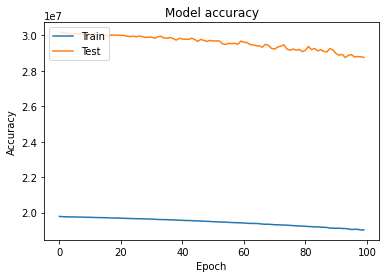

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
#Plot both the training accuracy as well as the validation accuracy on the same plot
plt.plot(hist.history['mse'])
plt.plot(hist.history['val_mse'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# LSTM

In [ ]:
from keras.layers.recurrent import LSTM,GRU
from keras.layers.normalization import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, SGD
from tensorflow.keras import regularizers
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Flatten, Dropout

Using TensorFlow backend.


In [ ]:
def lstm_change_shape(look_back,X_train,y_train,X_test,y_test):
  samples = len(X_train)
  num_features = X_train.shape[1]

  samples_train = X_train.shape[0] - look_back
  X_train_reshaped = np.zeros((samples_train, look_back, num_features)) # Initialize the required shape with an 'empty' zeros array.
  y_train_reshaped = np.zeros((samples_train))

  for i in range(samples_train):
    y_position = i + look_back
    X_train_reshaped[i] = X_train[i:y_position]
    y_train_reshaped[i] = y_train.iloc[y_position]

  samples_test = X_test.shape[0] - look_back
  X_test_reshaped = np.zeros((samples_test, look_back, num_features))
  y_test_reshaped = np.zeros((samples_test))

  for i in range(samples_test):
    y_position = i + look_back
    X_test_reshaped[i] =  X_test[i:y_position]
    y_test_reshaped[i] = y_test.iloc[y_position]
  
  print(X_train_reshaped.shape,y_train_reshaped.shape,X_test_reshaped.shape,y_test_reshaped.shape,num_features)
  return X_train_reshaped,y_train_reshaped,X_test_reshaped,y_test_reshaped,num_features

In [ ]:
look_back_world = 1
look_back_pak = 1

world_X_train_reshaped,world_y_train_reshaped,world_X_test_reshaped,world_y_test_reshaped,world_num_features = lstm_change_shape(look_back_world,world_X_train,world_y_train,world_X_test,world_y_test)
pak_X_train_reshaped,pak_y_train_reshaped,pak_X_test_reshaped,pak_y_test_reshaped,pak_num_features = lstm_change_shape(look_back_pak,pak_X_train,pak_y_train,pak_X_test,pak_y_test)

(4936, 1, 53) (4936,) (253, 1, 53) (253,) 53
(82, 1, 53) (82,) (27, 1, 53) (27,) 53


In [ ]:
def building_model(look_back,num_features):

  model = Sequential()
  model.add(LSTM(5, input_shape=(look_back, num_features), return_sequences=True, kernel_initializer='TruncatedNormal'))
  model.add(BatchNormalization())
  model.add(LeakyReLU())
  model.add(Dropout(0.3))

  model.add(LSTM(3, kernel_initializer='TruncatedNormal', return_sequences=False))
  model.add(BatchNormalization())
  model.add(LeakyReLU())
  model.add(Dropout(0.2))

  model.add(Dense(100, kernel_initializer='TruncatedNormal'))
  model.add(BatchNormalization())
  model.add(LeakyReLU())
  model.add(Dropout(0.3))

  model.add(Dense(32, kernel_initializer='TruncatedNormal'))
  model.add(BatchNormalization())
  model.add(LeakyReLU())
  model.add(Dropout(0.2))
      
  model.add(Dense(1))
  return model


In [ ]:
from keras.optimizers import Adam, SGD
Adam = Adam(lr = 0.001)

model_world = building_model(look_back_world,world_num_features)
model_world.compile(optimizer = Adam, loss = 'mse', metrics = ['mse'])

hist1 = model_world.fit(world_X_train_reshaped,world_y_train_reshaped, epochs = 200, batch_size = 128, validation_data =(world_X_test_reshaped,world_y_test_reshaped))

Train on 4936 samples, validate on 253 samples
Epoch 1/200
4936/4936 [==============================] - 4s 754us/step - loss: 20920262.9951 - mse: 20920264.0000 - val_loss: 16149008.0791 - val_mse: 16149008.0000
Epoch 2/200
4936/4936 [==============================] - 1s 156us/step - loss: 20916038.4198 - mse: 20916038.0000 - val_loss: 16147375.9130 - val_mse: 16147375.0000
Epoch 3/200
4936/4936 [==============================] - 1s 151us/step - loss: 20910056.1232 - mse: 20910050.0000 - val_loss: 16145664.2451 - val_mse: 16145664.0000
Epoch 4/200
4936/4936 [==============================] - 1s 154us/step - loss: 20904196.7715 - mse: 20904194.0000 - val_loss: 16143345.1067 - val_mse: 16143345.0000
Epoch 5/200
4936/4936 [==============================] - 1s 150us/step - loss: 20899247.8169 - mse: 20899250.0000 - val_loss: 16140338.3953 - val_mse: 16140338.0000
Epoch 6/200
4936/4936 [==============================] - 1s 150us/step - loss: 20892278.0389 - mse: 20892278.0000 - val_loss: 16

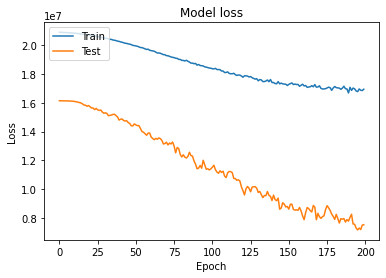

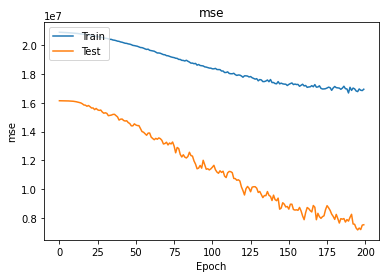

In [ ]:
plt.plot(hist1.history['loss'])
plt.plot(hist1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
#Plot both the training accuracy as well as the validation accuracy on the same plot
plt.plot(hist1.history['mse'])
plt.plot(hist1.history['val_mse'])
plt.title('mse')
plt.ylabel('mse')
plt.xlabel('Epoch')

plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
from keras.optimizers import Adam, SGD
model_pak = building_model(look_back_world,pak_num_features)

# transfering weights from world model to pak model
weights = model_world.get_weights()
model_pak.set_weights(weights)

Adam = Adam(lr = 0.01)
model_pak.compile(optimizer = Adam, loss = 'mse', metrics = ['mse'])

hist2 = model_pak.fit(pak_X_train_reshaped,pak_y_train_reshaped, epochs = 100, batch_size = 32, validation_data =(pak_X_test_reshaped,pak_y_test_reshaped))

Train on 82 samples, validate on 27 samples
Epoch 1/100
82/82 [==============================] - 1s 17ms/step - loss: 856296.9985 - mse: 856297.0000 - val_loss: 2172283.2500 - val_mse: 2172283.2500
Epoch 2/100
82/82 [==============================] - 0s 767us/step - loss: 891798.5884 - mse: 891798.6250 - val_loss: 1801589.6250 - val_mse: 1801589.6250
Epoch 3/100
82/82 [==============================] - 0s 669us/step - loss: 772959.1738 - mse: 772959.1875 - val_loss: 6690631.0000 - val_mse: 6690631.0000
Epoch 4/100
82/82 [==============================] - 0s 743us/step - loss: 658341.2630 - mse: 658341.2500 - val_loss: 10199301.0000 - val_mse: 10199301.0000
Epoch 5/100
82/82 [==============================] - 0s 774us/step - loss: 656878.2721 - mse: 656878.3125 - val_loss: 11259330.0000 - val_mse: 11259330.0000
Epoch 6/100
82/82 [==============================] - 0s 819us/step - loss: 588316.5091 - mse: 588316.5625 - val_loss: 11761510.0000 - val_mse: 11761510.0000
Epoch 7/100
82/82 [==

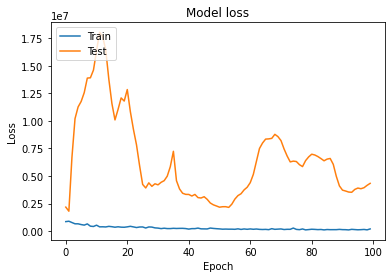

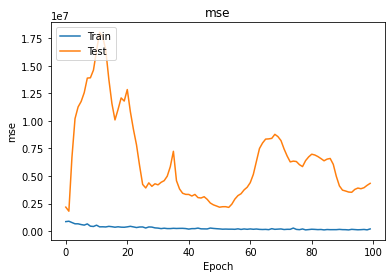

In [ ]:
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
#Plot both the training accuracy as well as the validation accuracy on the same plot
plt.plot(hist2.history['mse'])
plt.plot(hist2.history['val_mse'])
plt.title('mse')
plt.ylabel('mse')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
import math
y_pred = model_pak.predict(pak_X_test_reshaped)
# pak_y_test_reshaped_0 = np.reshape(pak_y_test_reshaped,(y_pred.shape[0],1))
print(y_pred.shape,pak_y_test_reshaped.shape)

from sklearn.metrics import mean_squared_error
print(math.sqrt(mean_squared_error(pak_y_test_reshaped,y_pred)))
#print(y_pred, pak_y_test_reshaped)

(27, 1) (27,)
2080.326853273822


### Graph

In [ ]:
X= df.copy(deep=True)
pak_dates = X[X['Pakistan']==1][split_index:]['date']
len(pak_dates[1:])

27

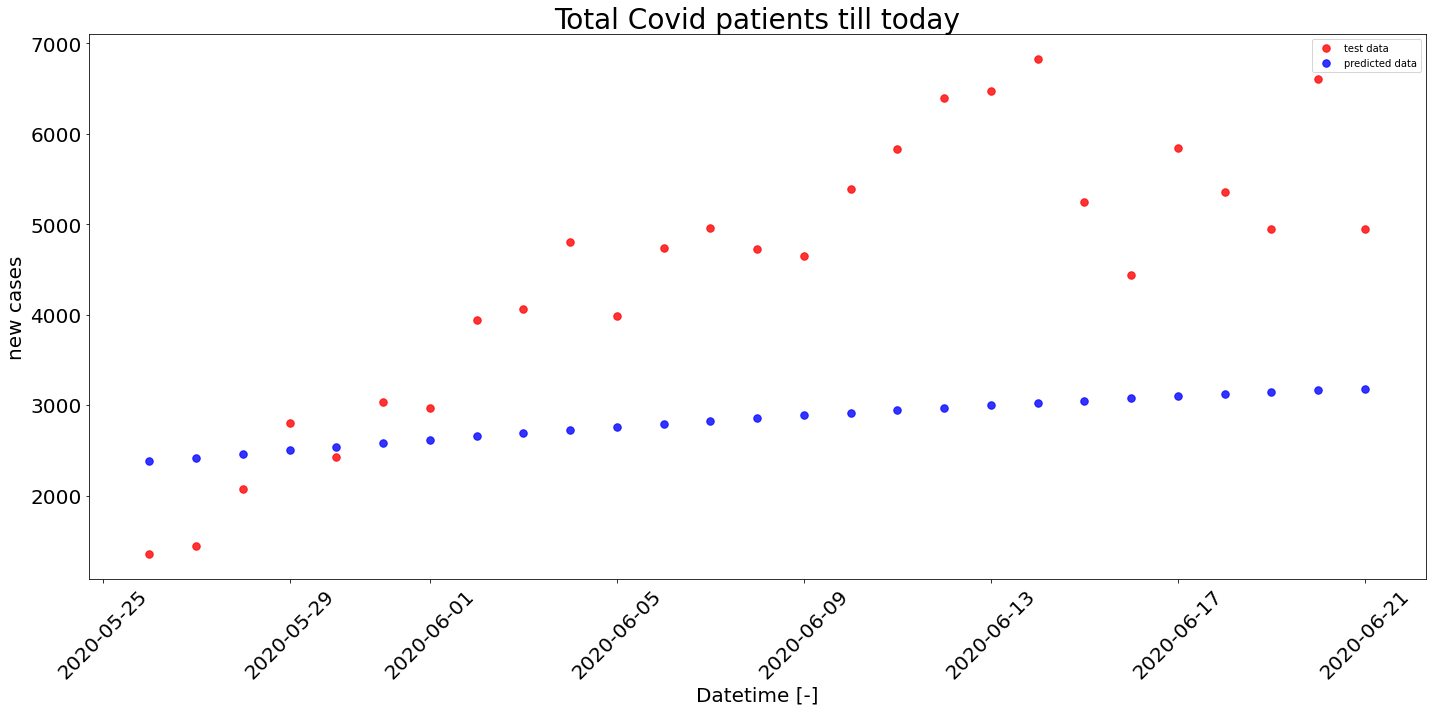

In [ ]:
X = df.copy(deep = True)
X = X.drop(["location"], axis = 1)
t = df[(df["Pakistan"] == 1)]["number_of_days"]

test_set = X[(X["Pakistan"] == 1) & (X["number_of_days"] >= max(t) -10)]

#print(test_set ["date"][1:].shape)
#Plotting the target: Total cases

plt.figure(figsize=(20,10))

plt.plot(pak_dates[1:], pak_y_test_reshaped, '.', color='red', label='Original data', alpha=0.8, markersize=15)
plt.plot(pak_dates[1:], y_pred, '.', color='blue', label='Original data', alpha=0.8, markersize=15)
plt.legend(["test data",'predicted data'])
plt.xlabel('Datetime [-]', fontsize=20)
plt.ylabel(r'new cases', fontsize=20)

plt.xticks(fontsize=20, rotation=45)
plt.yticks(fontsize=20)

plt.title('Total Covid patients till today', fontsize=28)

plt.tight_layout()
